In [1]:
from __future__ import print_function, division
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import data as dt
from torch.utils.data import DataLoader

In [2]:
# generate csv file, run only for the first time
dt.generate_csv()

In [5]:
csvFilePath = dt.get_csv_path()
transformed_dataset = dt.HE_SHG_Dataset(csv_file=csvFilePath,
                                               transform=dt.Compose([
                                               dt.ToTensor(),
                                               dt.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])                                               
                                           ]))
# TODO: change the normalization parameters

In [6]:
dataloader = DataLoader(transformed_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

0 torch.Size([32, 3, 100, 100]) torch.Size([32, 100, 100])
1 torch.Size([32, 3, 100, 100]) torch.Size([32, 100, 100])
2 torch.Size([32, 3, 100, 100]) torch.Size([32, 100, 100])
3 torch.Size([32, 3, 100, 100]) torch.Size([32, 100, 100])
torch.Size([32, 1, 100, 100])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


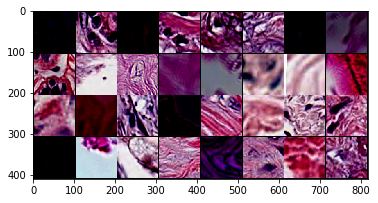

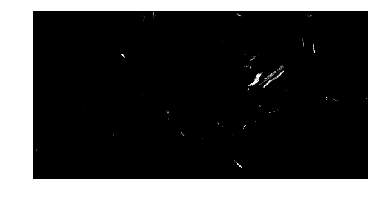

In [8]:
# TODO: insert back mean and variance to plot the image appropriately
dt.show_patch(dataloader) 